# Text Emotion Classification in Indonesian Public Opinion Tweet

#### Coded by M. Fazri Nizar, Sriwijaya University
#### Datasets by Ricco48

Traditional Classifiers used using Scikit-Learn:

1.   Naive Bayes
2.   Random Forest
3.   Logistic Regression
4.   Linear Support Vector


In [1]:
# @title 1. Clone Datasets and Install Requirements

!git clone https://github.com/mfazrinizar/text-emotion-classification-Indonesian-tweet.git
%cd text-emotion-classification-Indonesian-tweet
!pip install -r requirements.txt

Cloning into 'text-emotion-classification-Indonesian-tweet'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 23 (delta 0), reused 23 (delta 0), pack-reused 0
Receiving objects: 100% (23/23), 297.51 KiB | 2.61 MiB/s, done.
/content/text-emotion-classification-Indonesian-tweet


In [2]:
# @title 2. Load Required Libraries

import pandas as pd
import numpy as np

# Text Preprocessing Libraries
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import re

# Plots and Metrics Libraries
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# Feature Extraction / Vectorization Library
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Classifiers Libraries
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline

# Save and Load a File Library
import pickle

In [3]:
# @title 3. Load and Visualize Datasets

import pandas as pd
from sklearn.model_selection import train_test_split

# Define the paths to the datasets
paths = [
    'data/datasets/AngerData.csv',
    'data/datasets/FearData.csv',
    'data/datasets/JoyData.csv',
    'data/datasets/LoveData.csv',
    'data/datasets/NeutralData.csv',
    'data/datasets/SadData.csv'
]

# Initialize a list to hold the dataframes
dfs = []

# Read, clean, and combine the datasets
for path in paths:
    try:
        df = pd.read_csv(path, delimiter='\t', header=0)
        # Ensure the dataframe has exactly 2 columns
        if df.shape[1] == 2:
            dfs.append(df)
        else:
            print(f"File {path} does not have exactly 2 columns after cleaning.")
    except pd.errors.ParserError as e:
        print(f"Error parsing {path}: {e}")

# Check if all files were read successfully
if len(dfs) != len(paths):
    print("Some files were not read successfully. Please check the errors above.")
else:
    combined_df = pd.concat(dfs, ignore_index=True)

    # Split the data into train and test sets
    train_df, test_df = train_test_split(combined_df, test_size=0.3, random_state=42)

    # Save the train and test datasets
    train_df.to_csv('data/data_train.csv', index=False)
    test_df.to_csv('data/data_test.csv', index=False)

    print(f"Training data shape: {train_df.shape}")
    print(f"Test data shape: {test_df.shape}")


Training data shape: (4956, 2)
Test data shape: (2124, 2)


In [4]:
# @title 4. Load and Visualize Datasets

# Load the train and test datasets
df_train = pd.read_csv('data/data_train.csv')
df_test = pd.read_csv('data/data_test.csv')

X_train = df_train.Tweet
X_test = df_test.Tweet

y_train = df_train.Label
y_test = df_test.Label

class_names = ['Joy', 'Sad', 'Anger', 'Neutral', 'Fear', 'Love']
data = pd.concat([df_train, df_test])

print('Size of training set: %s' % (len(df_train['Tweet'])))
print('Size of validation set: %s' % (len(df_test['Tweet'])))
print(data.Label.value_counts())

data.head()

Size of training set: 4956
Size of validation set: 2124
Label
Neutral    2001
Joy        1275
Anger      1130
Sad        1003
Fear        911
Love        760
Name: count, dtype: int64


,Tweet,Label
0,"gapapa masih ada besok, ayoo tetap menyerah ja...",Sad
1,wkwk sama bangga banget merasa bener nebak jeo...,Joy
2,sedih aa. tahan ngantuk kot,Sad
3,tolong panik ini melanda lagi,Fear
4,rindumu sajak sentuhan. kalimatku pernah pucat...,Sad


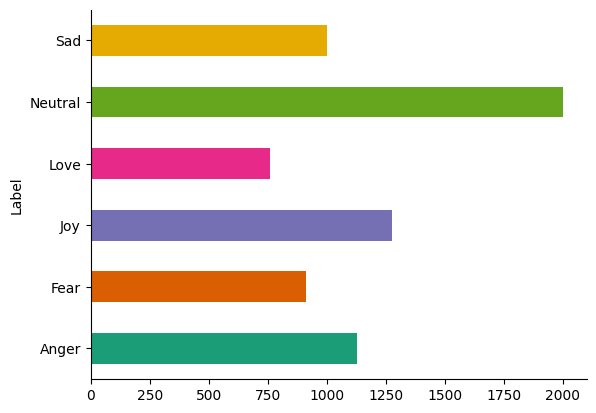

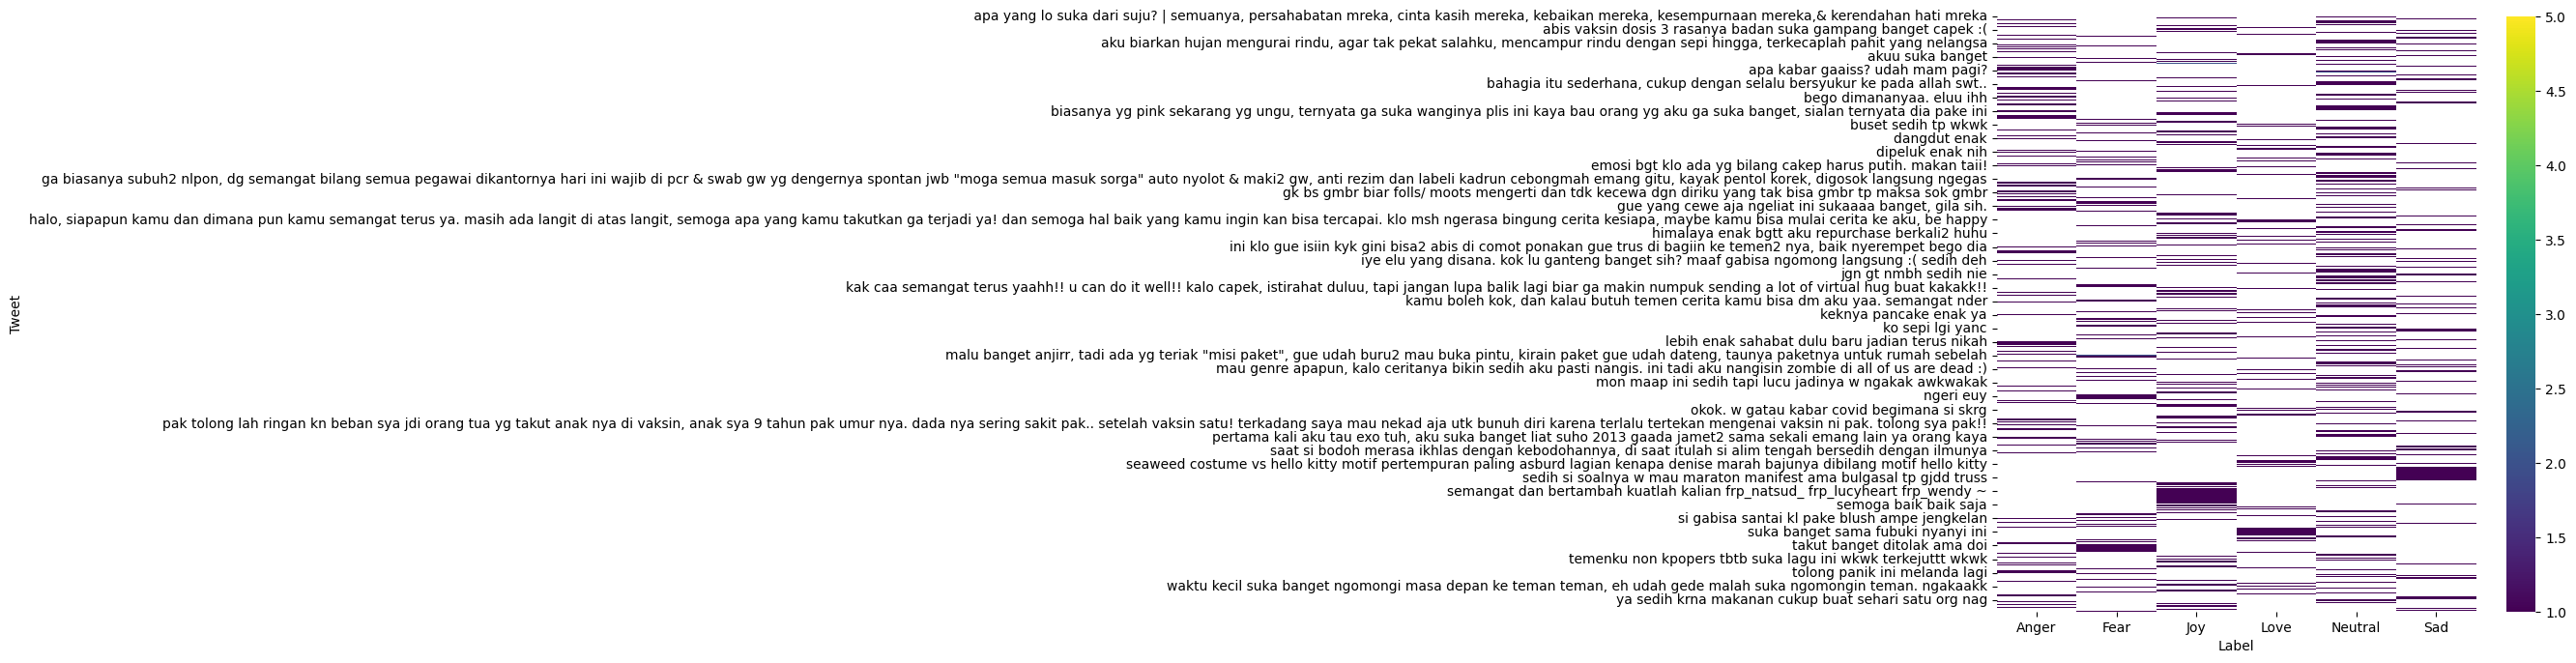

In [5]:
# @title 5. Visualize Datasets Composition in Bar Graph

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

data.groupby('Label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Tweet'].value_counts()
    for x_label, grp in data.groupby('Label') # Use 'data' instead of '_df_2'
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Label')
_ = plt.ylabel('Tweet')

In [6]:
# @title 6. Plotting Confusion Matrix for Later Evaluation (Reusable)

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    '''
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    '''
    if not title:
        if normalize:
            title = 'Normalized Confusion Matrix'
        else:
            title = 'Confusion Matrix, Without Normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()

    # Set size
    fig.set_size_inches(12.5, 7.5)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.grid(False)

    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True Label',
           xlabel='Predicted Label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [7]:
# @title 7. Text Preprocessing & Tokenization

def preprocess_and_tokenize(data):
    # remove html markup
    data = re.sub("(<.*?>)", "", data)

    # remove urls
    data = re.sub(r'http\S+', '', data)

    # remove hashtags and @names
    data= re.sub(r"(#[\d\w\.]+)", '', data)
    data= re.sub(r"(@[\d\w\.]+)", '', data)

    # remove punctuation and non-ascii digits
    data = re.sub("(\\W|\\d)", " ", data)

    # remove whitespace
    data = data.strip()

    # tokenization with nltk
    data = word_tokenize(data)

    # stemming with nltk
    porter = PorterStemmer()
    stem_data = [porter.stem(word) for word in data]

    return stem_data

In [8]:
# @title 8. Text Representation

import nltk

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

# TFIDF, unigrams and bigrams
vect = TfidfVectorizer(tokenizer=preprocess_and_tokenize, sublinear_tf=True, norm='l2', ngram_range=(1, 2), token_pattern=None)

# Fit on our complete corpus
vect.fit_transform(data.Tweet)

# Transform testing and training datasets to vectors
X_train_vect = vect.transform(X_train)
X_test_vect = vect.transform(X_test)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


# **9. Classifiers**

###1.   Naive Bayes
###2.   Random Forest
###3.   Logistic Regression
###4.   Linear Support Vector



Accuracy: 43.79%

F1 Score: 43.79

Confusion Matrix:
 [[ 67   0   0   0 289   0]
 [  0  32   1   0 248   0]
 [  0   1 171   3 210   0]
 [  0   0   2  29 185   0]
 [  3   0   6   0 580   0]
 [  0   0   2   0 244  51]]


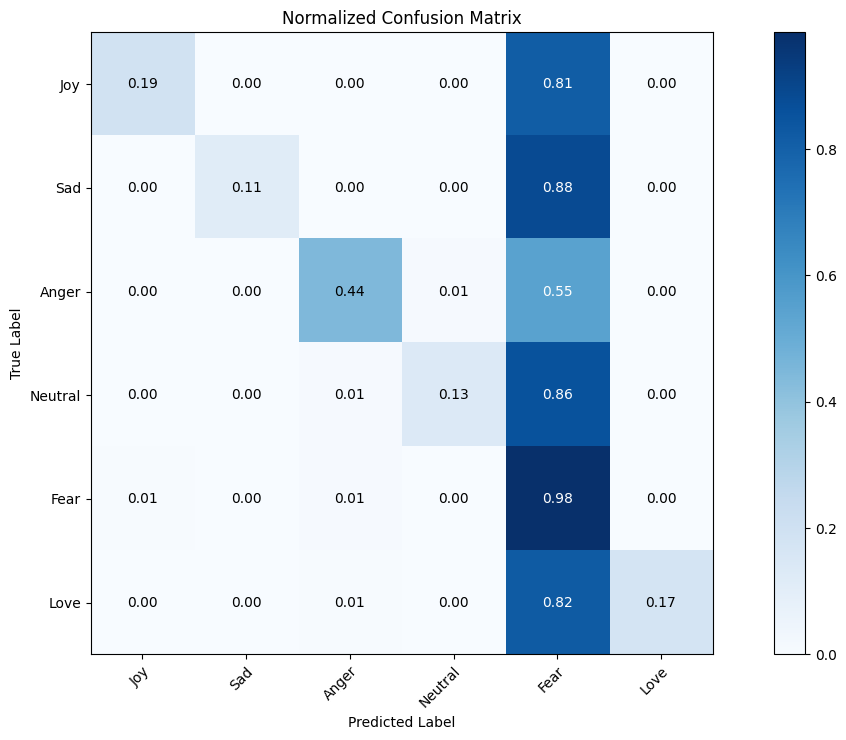

In [9]:
# @title Naive Bayes

nb = MultinomialNB()

nb.fit(X_train_vect, y_train)

ynb_pred = nb.predict(X_test_vect)

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

print("Accuracy: {:.2f}%".format(accuracy_score(y_test, ynb_pred) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, ynb_pred, average='micro') * 100))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, ynb_pred))

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, ynb_pred, classes=class_names, normalize=True, title='Normalized Confusion Matrix')
plt.show()

Accuracy: 68.13%

F1 Score: 68.13

Confusion Matrix:
 [[239   5   6  23  79   4]
 [ 10 203   5  12  48   3]
 [ 16  13 253  31  59  13]
 [  4   4   7 165  34   2]
 [ 43  29  38  30 417  32]
 [ 11   9  10  12  85 170]]


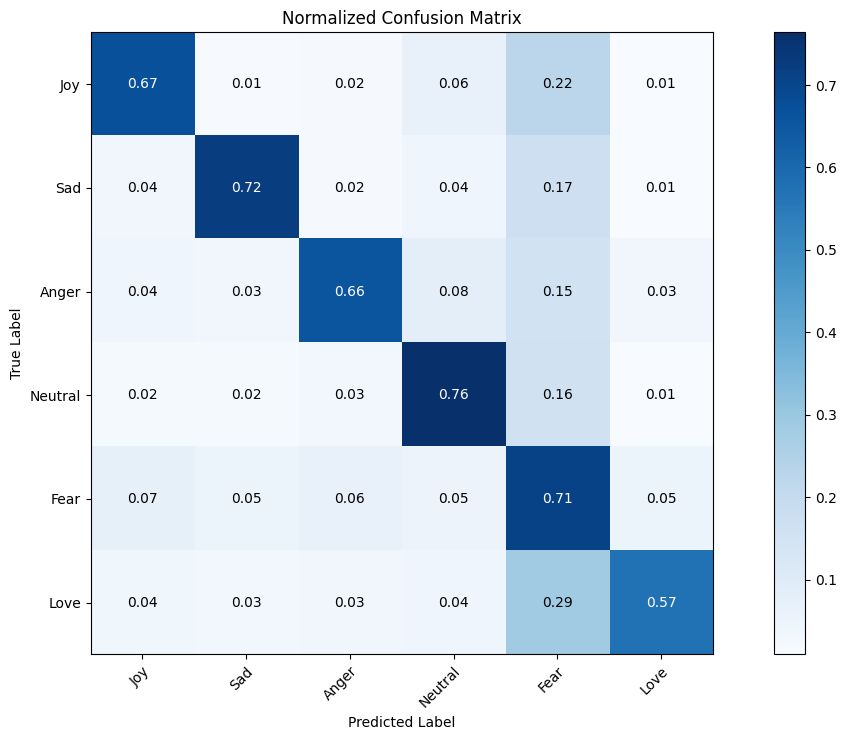

In [10]:
# @title Random Forest

rf = RandomForestClassifier(n_estimators=50)
rf.fit(X_train_vect, y_train)

yrf_pred = rf.predict(X_test_vect)

print("Accuracy: {:.2f}%".format(accuracy_score(y_test, yrf_pred) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, yrf_pred, average='micro') * 100))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, yrf_pred))

# Plot normalized confusion matrix

plot_confusion_matrix(y_test, yrf_pred, classes=class_names, normalize=True, title='Normalized Confusion Matrix')
plt.show()

Accuracy: 65.87%

F1 Score: 65.87

Confusion Matrix:
 [[202   3   4  14 130   3]
 [  5 178   3   3  91   1]
 [ 10  13 241  23  88  10]
 [  3   3  10 146  53   1]
 [ 28  21  24  18 478  20]
 [  7   7   6  11 112 154]]


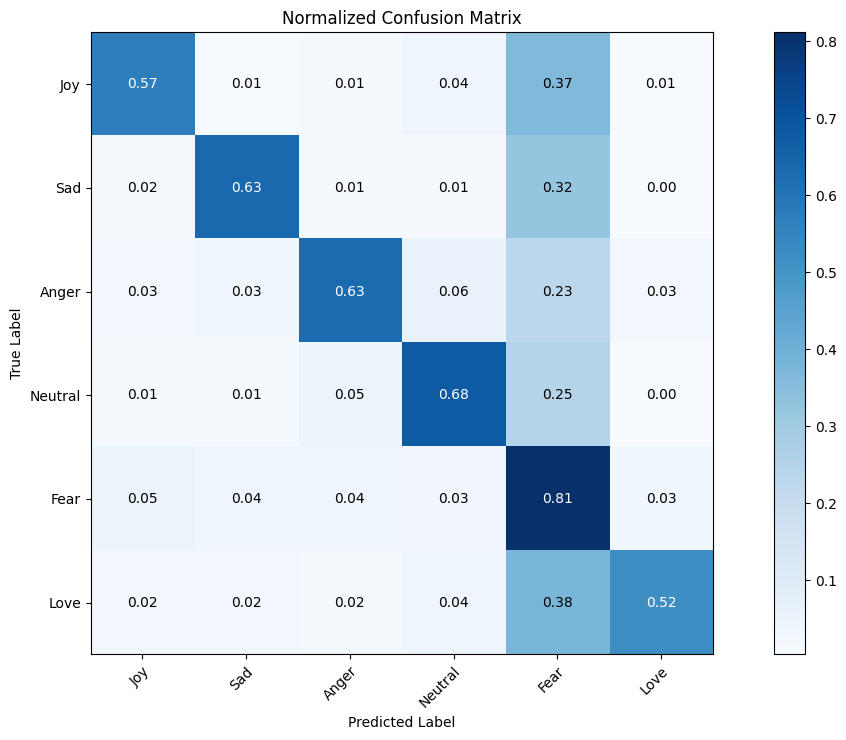

In [11]:
# @title Logistic Regression

log = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=200)
log.fit(X_train_vect, y_train)

ylog_pred = log.predict(X_test_vect)

print("Accuracy: {:.2f}%".format(accuracy_score(y_test, ylog_pred) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, ylog_pred, average='micro') * 100))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, ylog_pred))

# Plot normalized confusion matrix

plot_confusion_matrix(y_test, ylog_pred, classes=class_names, normalize=True, title='Normalized Confusion Matrix')
plt.show()

Accuracy: 70.95%

F1 Score: 70.95

Confusion Matrix:
 [[254   6   6  17  68   5]
 [  9 226   5   5  32   4]
 [ 12  17 268  26  49  13]
 [  4   2  11 168  24   7]
 [ 53  33  35  33 400  35]
 [ 11  10   8  10  67 191]]


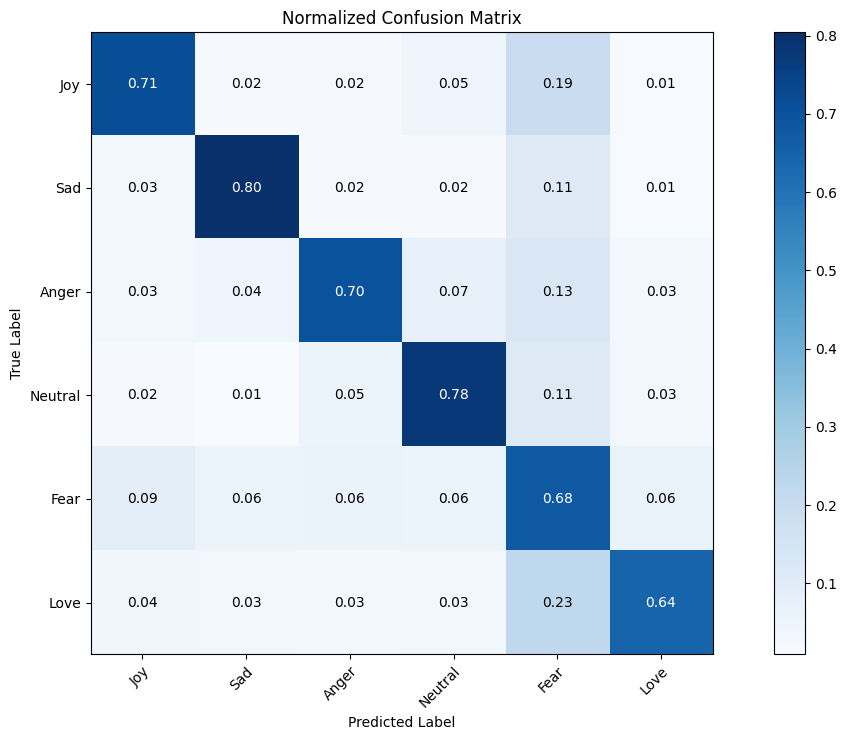

In [12]:
# @title Linear Support Vector

svc = LinearSVC(tol=1e-05)
svc.fit(X_train_vect, y_train)

ysvm_pred = svc.predict(X_test_vect)

print("Accuracy: {:.2f}%".format(accuracy_score(y_test, ysvm_pred) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, ysvm_pred, average='micro') * 100))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, ysvm_pred))

# Plot normalized confusion matrix

plot_confusion_matrix(y_test, ysvm_pred, classes=class_names, normalize=True, title='Normalized Confusion Matrix')
plt.show()

In [13]:
# @title 10. Saving the tf-idf + SVM Model
svm_model = Pipeline([
    ('tfidf', vect),
    ('clf', svc),
])

# Saving the model
filename = 'models/tfidf_svm.sav'
pickle.dump(svm_model, open(filename, 'wb'))

In [14]:
# Testing prediction

model = pickle.load(open(filename, 'rb'))

message = 'Lucu, Wak. Masa 1 + 1 = jendela, wkwk.'
model.predict([message])

array(['Joy'], dtype=object)